#Online learning with structured experts

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Simulate streaming data (binary classification task)
# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, random_state=42)

# Create an online learning pipeline with a StandardScaler and SGDClassifier
model = make_pipeline(StandardScaler(), SGDClassifier(loss='hinge'))

# Initialize the structured expert (SVM classifier)
svm_expert = SVC(kernel='rbf', C=1.0, gamma='scale')

# Online learning loop (simulate streaming data)
batch_size = 10
for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    y_batch = y[i:i+batch_size]

    # Update the structured expert (SVM classifier) with the current batch
    svm_expert.fit(X_batch, y_batch)

    # Fit the StandardScaler with the current batch (for online learning)
    model.named_steps['standardscaler'].partial_fit(X_batch)

    # Incorporate the structured expert into the online learning pipeline
    model.named_steps['sgdclassifier'].partial_fit(model.named_steps['standardscaler'].transform(X_batch), y_batch, classes=np.unique(y))

    # Evaluate the model's performance (optional)
    if (i+1) % 100 == 0:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"Batch {i+1}: Accuracy = {acc:.2f}")

# Final evaluation on the entire dataset
# Fit StandardScaler with entire dataset
model.named_steps['standardscaler'].fit(X)
# Transform the entire dataset using fitted StandardScaler
X_scaled = model.named_steps['standardscaler'].transform(X)
# Final prediction using the full dataset
y_pred_final = model.named_steps['sgdclassifier'].predict(X_scaled)
final_acc = accuracy_score(y, y_pred_final)
print(f"Final Accuracy: {final_acc:.2f}")


Final Accuracy: 0.80


#Hannan and Blackwell with Randomized Weighted Majority (RWM) Algorithm


In [ ]:
import random

class Forecaster:
    def __init__(self, num_experts):
        self.num_experts = num_experts
        self.weights = [1] * num_experts  # Initialize weights of experts
        self.experts = [self._initialize_expert() for _ in range(num_experts)]

    def _initialize_expert(self):
        # Example of initializing experts (can be customized for specific tasks)
        return lambda: random.choice([0, 1])  # Simple random predictor (binary outcome)

    def predict(self):
        # Weighted prediction based on expert opinions
        weighted_sum = sum(w * expert() for w, expert in zip(self.weights, self.experts))
        return 1 if weighted_sum >= 0.5 * sum(self.weights) else 0  # Binary prediction

    def update_weights(self, actual_outcome):
        # Update weights of experts based on actual outcome
        for i in range(self.num_experts):
            predicted_outcome = self.experts[i]()
            if predicted_outcome == actual_outcome:
                self.weights[i] *= 1.1  # Increase weight if correct
            else:
                self.weights[i] *= 0.9  # Decrease weight if incorrect

        # Normalize weights to maintain their sum
        total_weight = sum(self.weights)
        self.weights = [w / total_weight for w in self.weights]

# Simulation
num_rounds = 1000
forecaster = Forecaster(num_experts=5)

correct_predictions = 0
for _ in range(num_rounds):
    # Get actual outcome (simulate a stochastic environment)
    actual_outcome = random.choice([0, 1])

    # Make prediction
    prediction = forecaster.predict()

    # Update correct predictions count
    if prediction == actual_outcome:
        correct_predictions += 1

    # Update weights based on actual outcome
    forecaster.update_weights(actual_outcome)

# Calculate accuracy
accuracy = correct_predictions / num_rounds
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.50


#Weighted Average Prediction Strategy


The weighted average prediction strategy, often associated with the Hedge algorithm, aims to assign higher weights (or probabilities) to experts that have historically performed well in predicting outcomes. This allows the forecaster to effectively leverage the expertise of better-performing experts while gradually reducing the influence of underperforming ones.



In [ ]:
import random
import numpy as np

class WeightedAverageForecaster:
    def __init__(self, num_experts):
        self.num_experts = num_experts
        self.weights = np.ones(num_experts)  # Initialize weights uniformly
        self.experts = [self._initialize_expert() for _ in range(num_experts)]

    def _initialize_expert(self):
        # Example of initializing experts (can be customized for specific tasks)
        return lambda: random.choice([0, 1])  # Simple random predictor (binary outcome)

    def predict(self):
        # Weighted prediction based on expert opinions
        weighted_sum = sum(w * expert() for w, expert in zip(self.weights, self.experts))
        return 1 if weighted_sum >= 0.5 * sum(self.weights) else 0  # Binary prediction

    def update_weights(self, actual_outcome):
        # Update weights of experts based on actual outcome
        total_weight = sum(self.weights)
        for i in range(self.num_experts):
            predicted_outcome = self.experts[i]()
            if predicted_outcome == actual_outcome:
                self.weights[i] *= np.exp(0.1 / (self.num_experts * self.weights[i]))  # Increase weight if correct
            else:
                self.weights[i] *= np.exp(-0.1 / (self.num_experts * (1 - self.weights[i])))  # Decrease weight if incorrect

        # Normalize weights to maintain their sum
        self.weights /= sum(self.weights)

# Simulation
num_rounds = 1000
forecaster = WeightedAverageForecaster(num_experts=5)

correct_predictions = 0
for _ in range(num_rounds):
    # Get actual outcome (simulate a stochastic environment)
    actual_outcome = random.choice([0, 1])

    # Make prediction
    prediction = forecaster.predict()

    # Update correct predictions count
    if prediction == actual_outcome:
        correct_predictions += 1

    # Update weights based on actual outcome
    forecaster.update_weights(actual_outcome)

# Calculate accuracy
accuracy = correct_predictions / num_rounds
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.49


<ipython-input-4-71e9bebda32d>:27: RuntimeWarning: divide by zero encountered in scalar divide
  self.weights[i] *= np.exp(-0.1 / (self.num_experts * (1 - self.weights[i])))  # Decrease weight if incorrect
<ipython-input-4-71e9bebda32d>:25: RuntimeWarning: divide by zero encountered in scalar divide
  self.weights[i] *= np.exp(0.1 / (self.num_experts * self.weights[i]))  # Increase weight if correct
<ipython-input-4-71e9bebda32d>:25: RuntimeWarning: invalid value encountered in scalar multiply
  self.weights[i] *= np.exp(0.1 / (self.num_experts * self.weights[i]))  # Increase weight if correct


#Spanning Trees:

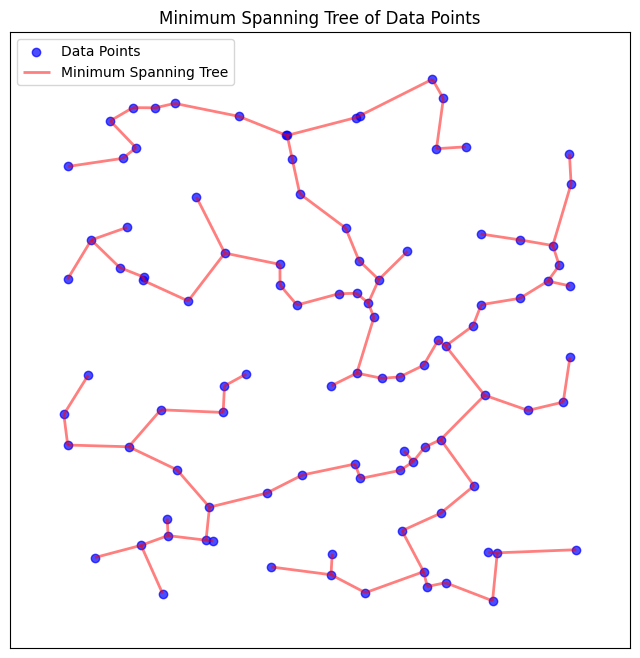

Number of clusters: 1


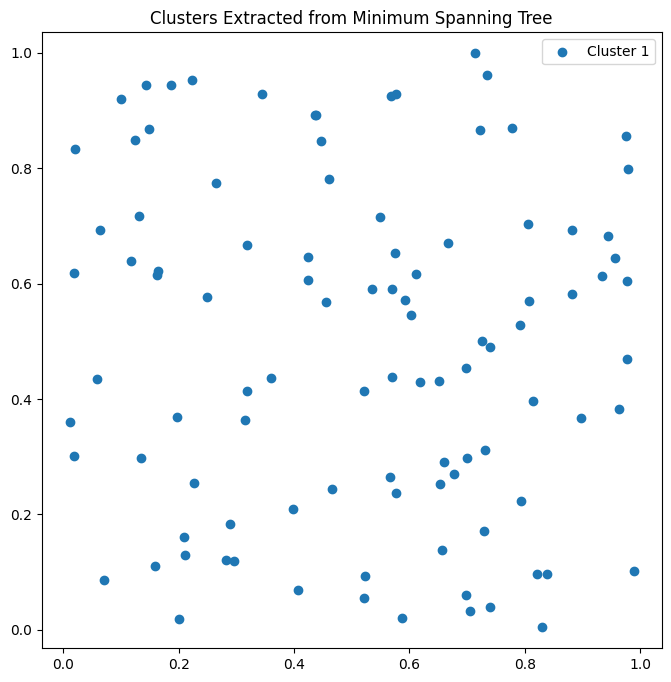

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx

# Generate random data points
np.random.seed(0)
X = np.random.rand(100, 2)

# Compute pairwise distances
dist_matrix = distance_matrix(X, X)

# Compute minimum spanning tree
mst = minimum_spanning_tree(dist_matrix)

# Extract edges from the MST
edges = []
for i in range(mst.shape[0]):
    for j in range(i + 1, mst.shape[1]):
        if mst[i, j] > 0:
            edges.append((i, j, mst[i, j]))

# Create a graph from the edges
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Visualize the original data points
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], color='b', alpha=0.7, label='Data Points')

# Draw the minimum spanning tree
pos = {i: (X[i, 0], X[i, 1]) for i in range(len(X))}
nx.draw_networkx_edges(G, pos, alpha=0.5, width=2, edge_color='r', label='Minimum Spanning Tree')

plt.title('Minimum Spanning Tree of Data Points')
plt.legend()
plt.axis('equal')
plt.show()

# Extract clusters from the MST
# We can use a threshold on edge weights to determine clusters
threshold = 0.2  # Example threshold for cluster separation
clusters = list(nx.connected_components(G))
print(f'Number of clusters: {len(clusters)}')

# Visualize clusters
plt.figure(figsize=(8, 8))
for idx, cluster in enumerate(clusters):
    cluster_points = X[list(cluster)]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {idx+1}')

plt.title('Clusters Extracted from Minimum Spanning Tree')
plt.legend()
plt.axis('equal')
plt.show()


#Follow the leader: random walk perturbation

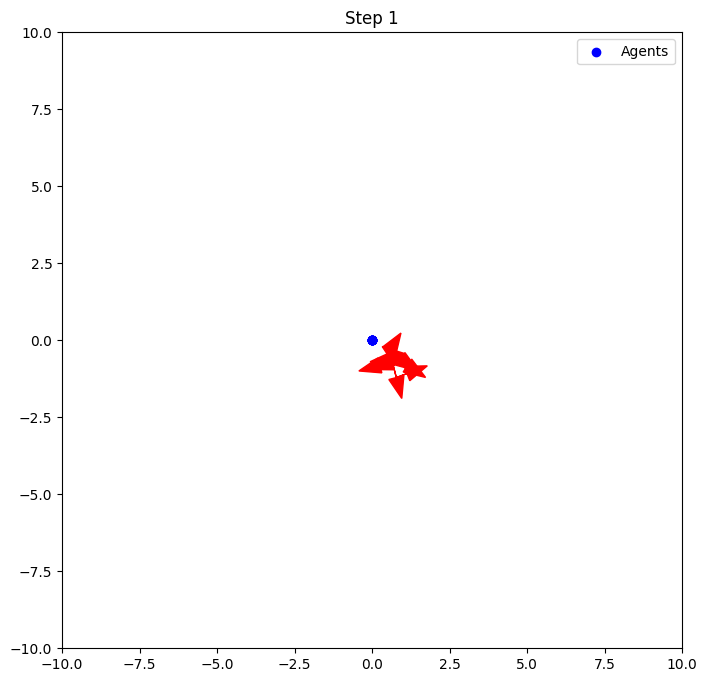

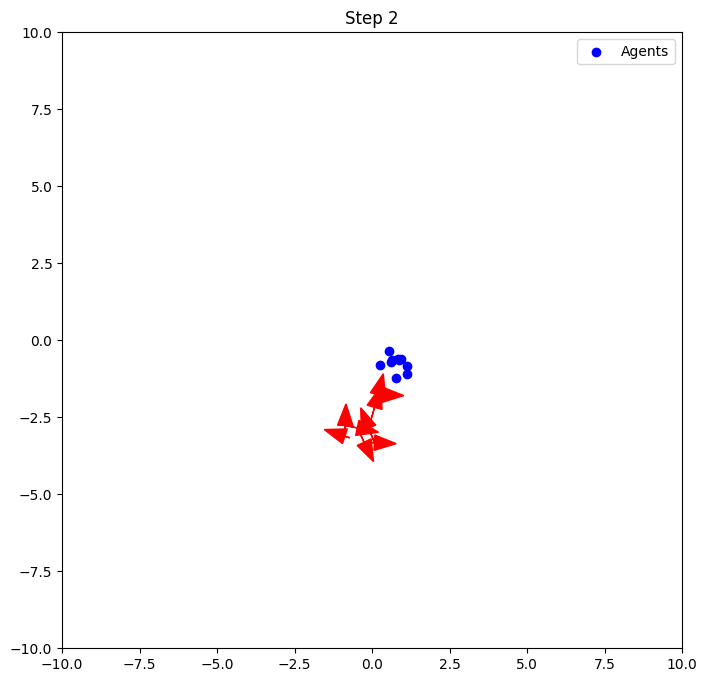

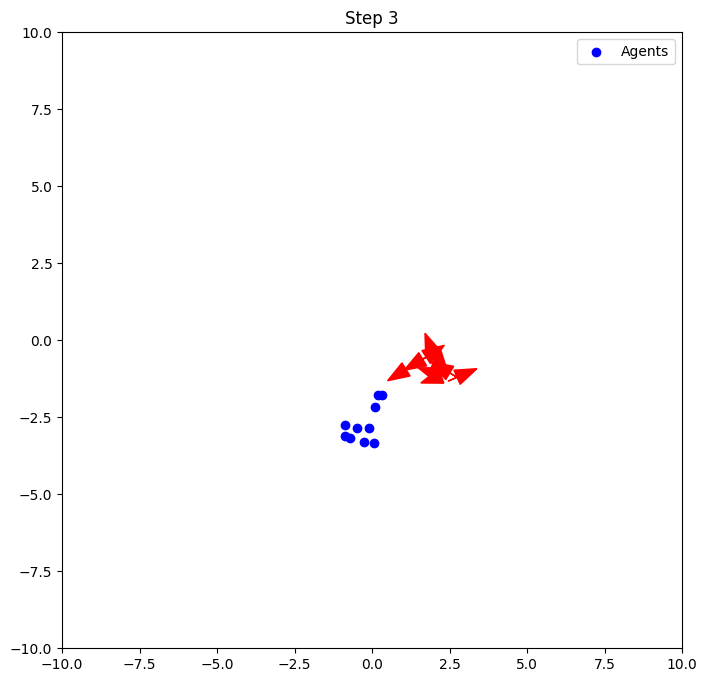

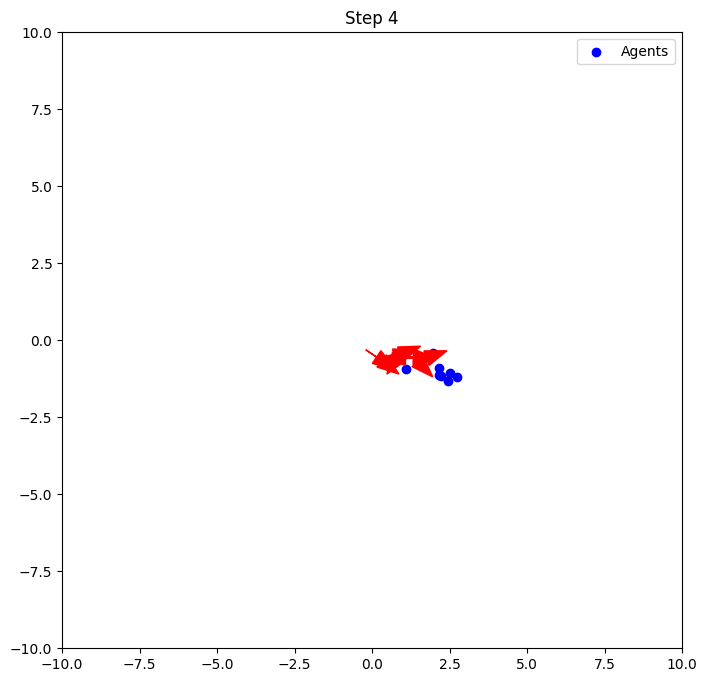

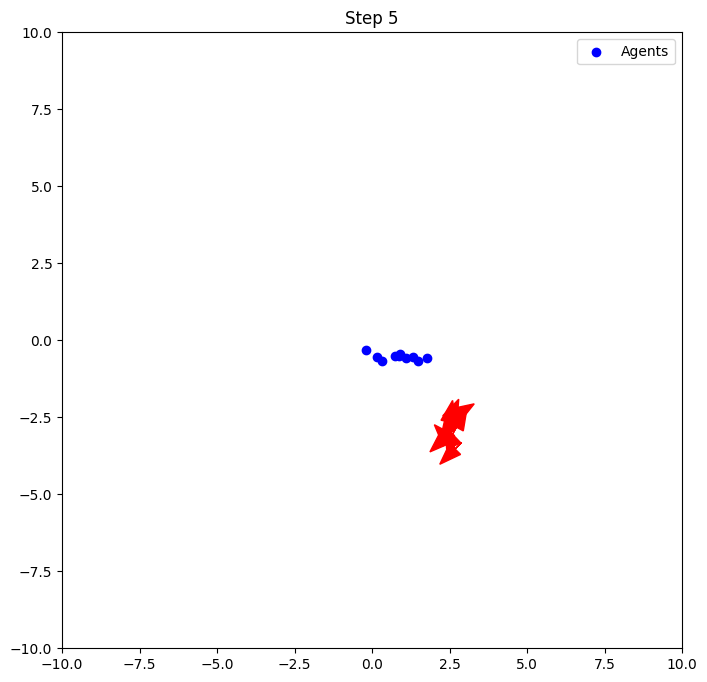

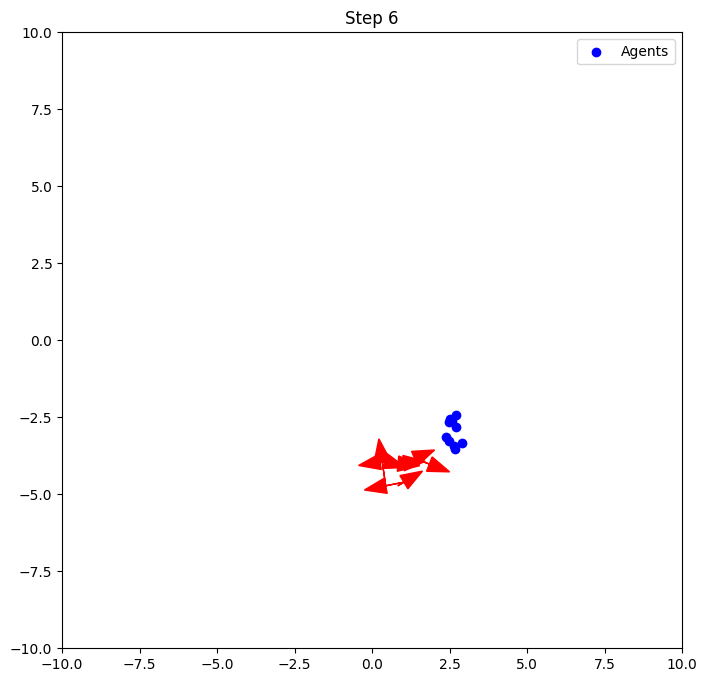

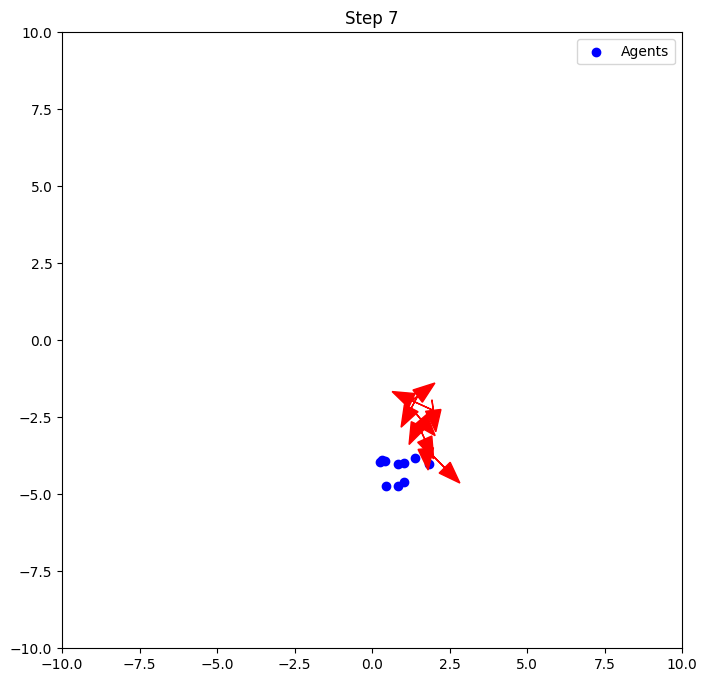

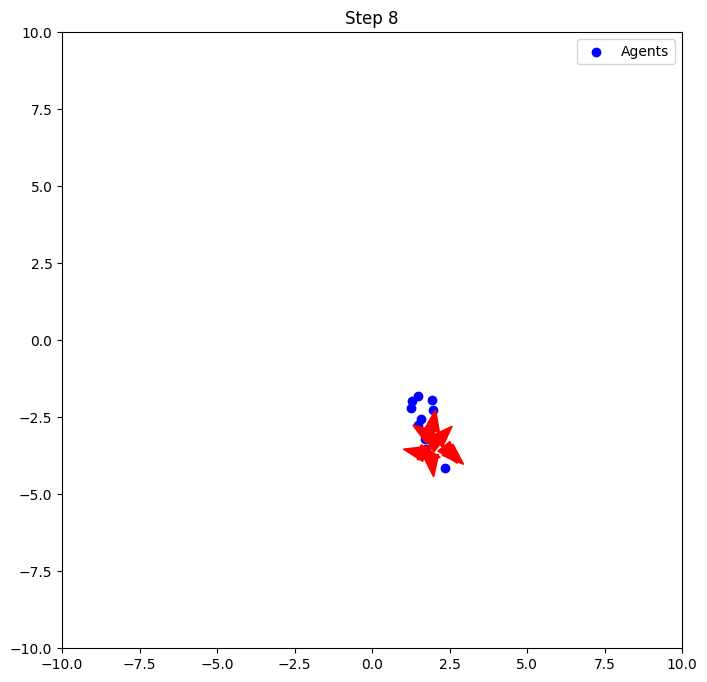

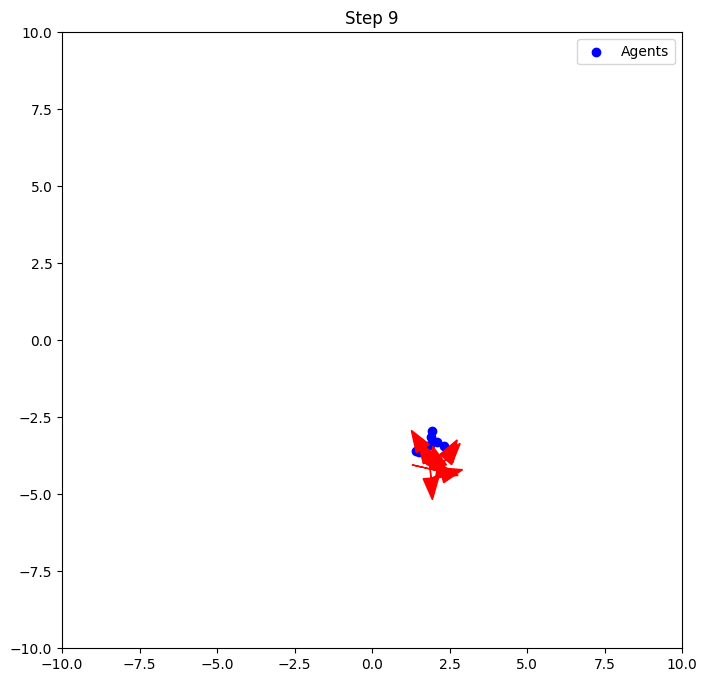

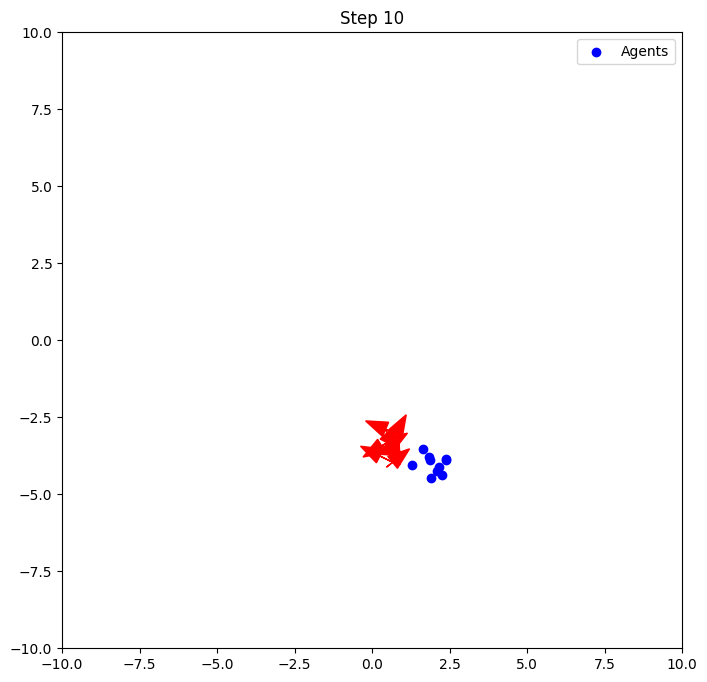

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def follow_the_leader_random_walk(num_agents, num_steps, step_size, perturbation_scale):
    # Initialize positions for each agent
    positions = np.zeros((num_agents, 2))  # (x, y) positions for each agent

    # Perform random walk for each step
    for step in range(num_steps):
        plt.figure(figsize=(8, 8))
        plt.title(f'Step {step + 1}')
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)

        # Plot positions of agents
        plt.scatter(positions[:, 0], positions[:, 1], color='b', label='Agents')

        # Update positions based on random walk
        for i in range(num_agents):
            if i == 0:
                # First agent moves randomly
                positions[i] += step_size * np.random.randn(2)
            else:
                # Other agents follow the leader with perturbation
                direction = positions[i - 1] - positions[i]
                perturbation = perturbation_scale * np.random.randn(2)
                positions[i] += step_size * direction + perturbation

        # Plot arrows indicating movement direction
        for i in range(num_agents):
            if i > 0:
                direction = positions[i - 1] - positions[i]
                plt.arrow(positions[i, 0], positions[i, 1], direction[0], direction[1],
                          head_width=0.5, head_length=0.7, fc='r', ec='r')

        # Display plot
        plt.legend()
        plt.show()

# Parameters
num_agents = 10
num_steps = 10
step_size = 1.0
perturbation_scale = 0.3

# Run simulation
follow_the_leader_random_walk(num_agents, num_steps, step_size, perturbation_scale)


#Multi-armed bandits


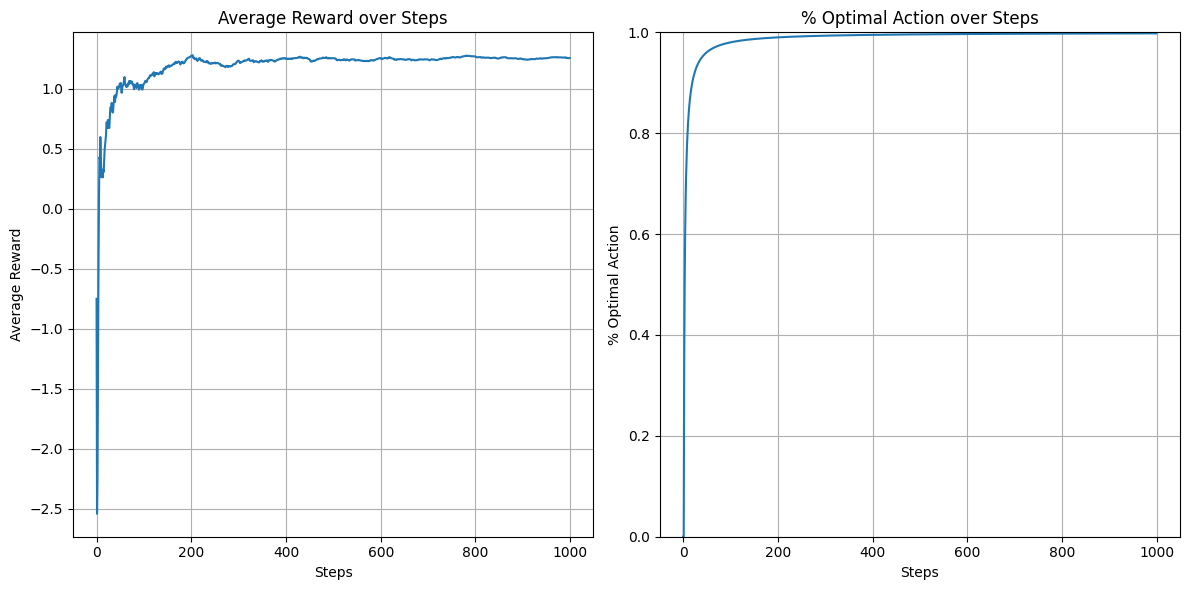

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MultiArmedBandit:
    def __init__(self, num_arms, true_reward_means):
        self.num_arms = num_arms
        self.true_reward_means = true_reward_means
        self.reset()

    def reset(self):
        self.q_true = np.random.normal(self.true_reward_means, 1.0, size=self.num_arms)
        self.q_estimates = np.zeros(self.num_arms)
        self.action_counts = np.zeros(self.num_arms)
        self.total_reward = 0
        self.optimal_arm = np.argmax(self.q_true)
        self.steps = 0

    def choose_action(self, epsilon):
        if np.random.random() < epsilon:
            # Explore: choose a random arm
            action = np.random.randint(self.num_arms)
        else:
            # Exploit: choose the arm with the highest estimated value (greedy)
            action = np.argmax(self.q_estimates)

        self.action_counts[action] += 1
        reward = np.random.normal(self.q_true[action], 1.0)  # Reward from chosen arm
        self.total_reward += reward
        self.steps += 1

        # Update action value estimate (sample-average method)
        self.q_estimates[action] += (reward - self.q_estimates[action]) / self.action_counts[action]

        return reward

    def run_bandit(self, num_steps, epsilon):
        self.reset()
        rewards = []
        optimal_actions = []

        for _ in range(num_steps):
            reward = self.choose_action(epsilon)
            rewards.append(reward)
            optimal_actions.append(1 if self.optimal_arm == np.argmax(self.q_estimates) else 0)

        return rewards, optimal_actions

# Parameters
num_arms = 10
true_reward_means = np.random.normal(0, 1, size=num_arms)
num_steps = 1000
epsilon = 0.1

# Run multi-armed bandit simulation
bandit = MultiArmedBandit(num_arms, true_reward_means)
rewards, optimal_actions = bandit.run_bandit(num_steps, epsilon)

# Plot results
plt.figure(figsize=(12, 6))

# Plot average reward per step
plt.subplot(1, 2, 1)
plt.plot(np.arange(num_steps), np.cumsum(rewards) / np.arange(1, num_steps + 1), label='Average Reward')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward over Steps')
plt.grid()

# Plot % optimal action per step
plt.subplot(1, 2, 2)
plt.plot(np.arange(num_steps), np.cumsum(optimal_actions) / np.arange(1, num_steps + 1), label='% Optimal Action')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.title('% Optimal Action over Steps')
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()


#Prediction with partial monitoring

In [ ]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Load and preprocess the Iris dataset using TensorFlow's built-in dataset
iris_data = load_iris()

# Extract features (X) and labels (y) from the dataset
X = iris_data.data
y = iris_data.target

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Choose and train multiple classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Train each classifier
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"Trained {name} model.")

# Step 4: Define a simple partial monitoring prediction strategy
def predict_with_partial_monitoring(models, X):
    predictions = []
    for name, model in models.items():
        prediction = model.predict(X)
        predictions.append(prediction)
    # Use simple majority voting for prediction
    final_prediction = tf.reduce_mean(predictions, axis=0)
    return final_prediction

# Step 5: Make predictions and evaluate performance
y_pred = predict_with_partial_monitoring(models, X_test)

# Convert float predictions to integers
y_pred = y_pred.numpy().astype(int)

# Evaluate performance using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Trained Logistic Regression model.
Trained Decision Tree model.
Trained Random Forest model.
Trained Support Vector Machine model.
Test Accuracy: 1.0


#Combinatorial prediction game


In [ ]:
import random

def roll_dice(num_dice):
    """Simulates rolling a given number of dice and returns the total."""
    return sum(random.randint(1, 6) for _ in range(num_dice))

def play_combinatorial_prediction(num_dice):
    """Main function to play the combinatorial prediction game."""
    print("Welcome to the Combinatorial Prediction Game!")
    print(f"You will roll {num_dice} dice. Try to predict the total value.\n")

    while True:
        try:
            prediction = int(input("Enter your prediction (total value): "))
            break
        except ValueError:
            print("Invalid input. Please enter a valid integer prediction.")

    # Roll the dice
    actual_total = roll_dice(num_dice)

    # Display the result
    print(f"\nThe dice are rolled...")
    print(f"The actual total is: {actual_total}")

    # Calculate the difference between prediction and actual
    difference = abs(prediction - actual_total)

    if difference == 0:
        print("Congratulations! Your prediction was spot on.")
        points = 3
    elif difference <= 2:
        print("Very close! You almost got it right.")
        points = 2
    elif difference <= 5:
        print("Not bad. You were somewhat close.")
        points = 1
    else:
        print("Oops! Your prediction was quite off.")
        points = 0

    print(f"You earned {points} points.\n")

    # Ask if the player wants to play again
    play_again = input("Do you want to play again? (yes/no): ").lower()
    if play_again.startswith('y'):
        play_combinatorial_prediction(num_dice)
    else:
        print("Thanks for playing!")

# Start the game with 2 dice (you can change this number)
play_combinatorial_prediction(2)


Welcome to the Combinatorial Prediction Game!
You will roll 2 dice. Try to predict the total value.

Enter your prediction (total value): 78

The dice are rolled...
The actual total is: 5
Oops! Your prediction was quite off.
You earned 0 points.

Do you want to play again? (yes/no): y
Welcome to the Combinatorial Prediction Game!
You will roll 2 dice. Try to predict the total value.

Enter your prediction (total value): 3

The dice are rolled...
The actual total is: 8
Not bad. You were somewhat close.
You earned 1 points.

Do you want to play again? (yes/no): y
Welcome to the Combinatorial Prediction Game!
You will roll 2 dice. Try to predict the total value.

Enter your prediction (total value): 5

The dice are rolled...
The actual total is: 9
Not bad. You were somewhat close.
You earned 1 points.

Do you want to play again? (yes/no): n
Thanks for playing!


#Hamiltonian cycles


In [ ]:
class HamiltonianCycleFinder:
    def __init__(self, adjacency_matrix):
        self.adjacency_matrix = adjacency_matrix
        self.num_vertices = len(adjacency_matrix)
        self.hamiltonian_cycle = []

    def is_valid(self, v, pos, path):
        """Check if vertex v can be added to the path."""
        # Check if this vertex is an adjacent vertex of the previously added vertex.
        if self.adjacency_matrix[path[pos - 1]][v] == 0:
            return False

        # Check if the vertex has already been included.
        if v in path:
            return False

        return True

    def hamiltonian_cycle_util(self, path, pos):
        """Recursive utility function to find Hamiltonian cycle."""
        if pos == self.num_vertices:
            # Check if there's an edge from the last added vertex to the first vertex.
            if self.adjacency_matrix[path[pos - 1]][path[0]] == 1:
                return True
            else:
                return False

        for v in range(1, self.num_vertices):
            if self.is_valid(v, pos, path):
                path[pos] = v

                if self.hamiltonian_cycle_util(path, pos + 1):
                    return True

                # Backtrack
                path[pos] = -1

        return False

    def find_hamiltonian_cycle(self):
        """Find and display a Hamiltonian cycle if it exists."""
        path = [-1] * self.num_vertices
        path[0] = 0  # Start from vertex 0

        if not self.hamiltonian_cycle_util(path, 1):
            print("No Hamiltonian cycle exists for this graph.")
            return False

        self.hamiltonian_cycle = path
        self.display_hamiltonian_cycle()
        return True

    def display_hamiltonian_cycle(self):
        """Display the Hamiltonian cycle."""
        print("Hamiltonian Cycle:")
        for vertex in self.hamiltonian_cycle:
            print(vertex, end=" -> ")
        print(self.hamiltonian_cycle[0])  # Complete the cycle


# Example usage:
if __name__ == "__main__":
    # Example adjacency matrix (change this for different graphs)
    adjacency_matrix = [
        [0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1],
        [1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0]
    ]

    # Create HamiltonianCycleFinder instance
    hc_finder = HamiltonianCycleFinder(adjacency_matrix)

    # Find and display Hamiltonian cycle
    hc_finder.find_hamiltonian_cycle()

Hamiltonian Cycle:
0 -> 1 -> 4 -> 3 -> 2 -> 0


#Minimax regret


In [ ]:
import numpy as np

def compute_payoffs(player1_strategies, player2_strategies):
    """Compute payoffs for a two-player zero-sum game."""
    num_strategies_p1 = len(player1_strategies)
    num_strategies_p2 = len(player2_strategies)

    payoffs = np.zeros((num_strategies_p1, num_strategies_p2))

    # Populate payoffs matrix with random values (for demonstration)
    for i in range(num_strategies_p1):
        for j in range(num_strategies_p2):
            # Simulated payoffs (replace with actual logic for your game)
            payoffs[i][j] = np.random.randint(-10, 10)  # Random payoffs [-10, 10]

    return payoffs

def compute_minimax_regret(payoffs):
    """Compute the minimax regret strategy for each player."""
    num_strategies_p1, num_strategies_p2 = payoffs.shape

    # Compute max payoff for each strategy of player 1
    max_payoff_p1 = np.max(payoffs, axis=1)

    # Compute max payoff for each strategy of player 2 (minimize for player 1)
    min_payoff_p2 = np.min(payoffs, axis=1)

    # Compute regrets for each strategy combination
    regrets = np.zeros_like(payoffs)
    for i in range(num_strategies_p1):
        for j in range(num_strategies_p2):
            regrets[i][j] = max_payoff_p1[i] - payoffs[i][j]

    # Compute minimax regret strategy indices
    minimax_regret_indices_p1 = np.argmin(regrets, axis=1)
    minimax_regret_indices_p2 = np.argmin(regrets, axis=0)

    return minimax_regret_indices_p1, minimax_regret_indices_p2

def display_minimax_regret_strategy(player1_strategies, player2_strategies, minimax_regret_indices_p1, minimax_regret_indices_p2):
    """Display the minimax regret strategy for each player."""
    print("Player 1 Minimax Regret Strategy:")
    for i, idx in enumerate(minimax_regret_indices_p1):
        print(f"Play '{player1_strategies[i]}' if opponent plays '{player2_strategies[idx]}'")

    print("\nPlayer 2 Minimax Regret Strategy:")
    for j, idx in enumerate(minimax_regret_indices_p2):
        print(f"Play '{player2_strategies[j]}' if opponent plays '{player1_strategies[idx]}'")

# Example usage:
if __name__ == "__main__":
    # Define player strategies (Rock-Paper-Scissors example)
    player1_strategies = ["Rock", "Paper", "Scissors"]
    player2_strategies = ["Rock", "Paper", "Scissors"]

    # Compute payoffs for a simplified zero-sum game
    payoffs = compute_payoffs(player1_strategies, player2_strategies)

    # Compute minimax regret strategy
    minimax_regret_indices_p1, minimax_regret_indices_p2 = compute_minimax_regret(payoffs)

    # Display the minimax regret strategy
    display_minimax_regret_strategy(player1_strategies, player2_strategies, minimax_regret_indices_p1, minimax_regret_indices_p2)


Player 1 Minimax Regret Strategy:
Play 'Rock' if opponent plays 'Scissors'
Play 'Paper' if opponent plays 'Rock'
Play 'Scissors' if opponent plays 'Paper'

Player 2 Minimax Regret Strategy:
Play 'Rock' if opponent plays 'Paper'
Play 'Paper' if opponent plays 'Scissors'
Play 'Scissors' if opponent plays 'Rock'


#CLEB (Combinatorial LEarning with Bregman divergences)


In [ ]:
import numpy as np

class CLEB:
    def __init__(self, learning_rate=0.1, num_iterations=1000, reg_param=0.1, divergence='kl'):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.reg_param = reg_param
        self.divergence = divergence

    def _bregman_divergence(self, u, v):
        """ Compute the Bregman divergence between u and v based on the chosen divergence type """
        if self.divergence == 'kl':
            return np.sum(u * np.log(u / v) - u + v)
        elif self.divergence == 'euclidean':
            return np.sum((u - v)**2)
        else:
            raise ValueError(f"Unsupported divergence type: {self.divergence}")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.rand(n_features)  # Initialize weights

        for _ in range(self.num_iterations):
            # Compute predictions
            scores = X.dot(self.weights)
            probabilities = np.exp(scores) / np.sum(np.exp(scores))

            # Compute loss and gradient
            loss = np.mean([self._bregman_divergence(y[i], probabilities[i]) for i in range(n_samples)])
            grad = X.T.dot(probabilities - y) / n_samples + self.reg_param * self.weights

            # Update weights using gradient descent
            self.weights -= self.learning_rate * grad

    def predict(self, X):
        scores = X.dot(self.weights)
        probabilities = np.exp(scores) / np.sum(np.exp(scores))
        return probabilities

# Example usage:
if __name__ == "__main__":
    # Generate synthetic dataset
    np.random.seed(0)
    X = np.random.rand(100, 2)
    true_weights = np.array([0.3, -0.5])
    y_proba = np.exp(X.dot(true_weights)) / np.sum(np.exp(X.dot(true_weights)))
    y = np.random.binomial(1, y_proba, size=len(X))

    # Initialize and train CLEB model
    cleb_model = CLEB(learning_rate=0.1, num_iterations=1000, reg_param=0.1, divergence='kl')
    cleb_model.fit(X, y)

    # Predict probabilities for new data
    X_new = np.array([[0.6, 0.4]])
    probabilities = cleb_model.predict(X_new)
    print("Predicted probabilities:", probabilities)


<ipython-input-29-3a0979401cec>:13: RuntimeWarning: divide by zero encountered in log
  return np.sum(u * np.log(u / v) - u + v)
<ipython-input-29-3a0979401cec>:13: RuntimeWarning: invalid value encountered in scalar multiply
  return np.sum(u * np.log(u / v) - u + v)


Predicted probabilities: [1.]


#Di↵erent instances of CLEB: LinExp (Entropy Function)


In [ ]:
import numpy as np

class CLEB_LinExp:
    def __init__(self, learning_rate=0.1, num_iterations=1000, reg_param=0.1, alpha=0.5):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.reg_param = reg_param
        self.alpha = alpha

    def _linexp_divergence(self, u, v):
        """ Compute the LinExp divergence between u and v """
        return np.sum(u * np.log(u / v) + (v - u) * (1 - np.exp(-(u - v) / self.alpha)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.rand(n_features)  # Initialize weights

        for _ in range(self.num_iterations):
            # Compute predictions
            scores = X.dot(self.weights)
            probabilities = np.exp(scores) / np.sum(np.exp(scores))

            # Compute loss and gradient using LinExp divergence
            loss = np.mean([self._linexp_divergence(y[i], probabilities[i]) for i in range(n_samples)])
            grad = X.T.dot(probabilities - y) / n_samples + self.reg_param * self.weights

            # Update weights using gradient descent
            self.weights -= self.learning_rate * grad

    def predict(self, X):
        scores = X.dot(self.weights)
        probabilities = np.exp(scores) / np.sum(np.exp(scores))
        return probabilities

# Example usage:
if __name__ == "__main__":
    # Generate synthetic dataset
    np.random.seed(0)
    X = np.random.rand(100, 2)
    true_weights = np.array([0.3, -0.5])
    y_proba = np.exp(X.dot(true_weights)) / np.sum(np.exp(X.dot(true_weights)))
    y = np.random.binomial(1, y_proba, size=len(X))

    # Initialize and train CLEB-LinExp model
    cleb_linexp_model = CLEB_LinExp(learning_rate=0.1, num_iterations=1000, reg_param=0.1, alpha=0.5)
    cleb_linexp_model.fit(X, y)

    # Predict probabilities for new data
    X_new = np.array([[0.6, 0.4]])
    probabilities = cleb_linexp_model.predict(X_new)
    print("Predicted probabilities (CLEB-LinExp):", probabilities)

<ipython-input-30-d202daa39547>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(u * np.log(u / v) + (v - u) * (1 - np.exp(-(u - v) / self.alpha)))
<ipython-input-30-d202daa39547>:12: RuntimeWarning: invalid value encountered in scalar multiply
  return np.sum(u * np.log(u / v) + (v - u) * (1 - np.exp(-(u - v) / self.alpha)))


Predicted probabilities (CLEB-LinExp): [1.]
